## CNN-LSTM IoMT IDS
### CSCI 6505 Group Project
### Author: Hongwei Zhang & Koil Jat Chong
### Enhancing Intrusion Detection in Healthcare IoMT Devices Using the CNN-LSTM Model

In [1]:
import sys
import os
import pandas as pd
import torch
import warnings
warnings.simplefilter('ignore')
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.optim as optim
print("Python version:", sys.version)
print("Version info:", sys.version_info)

Python version: 3.10.11 (tags/v3.10.11:7d4cc5a, Apr  5 2023, 00:38:17) [MSC v.1929 64 bit (AMD64)]
Version info: sys.version_info(major=3, minor=10, micro=11, releaselevel='final', serial=0)


In [2]:
# Read the dataset files list
file_list = pd.read_csv('./dataset/file_list.csv')
file_list.head()

,File,Category,Attack,Class
0,ARP_Spoofing_train.pcap.csv,SPOOFING,ARP Spoofing,1
1,Benign_train.pcap.csv,BENIGN,Benign,0
2,MQTT-DDoS-Connect_Flood_train.pcap.csv,MQTT,DDoS Connect Flood,1
3,MQTT-DDoS-Publish_Flood_train.pcap.csv,MQTT,DDoS Publish Flood,1
4,MQTT-DoS-Connect_Flood_train.pcap.csv,MQTT,DoS Connect Flood,1


In [3]:
# Import the dataset
data_dir = "./dataset/"
first_file_path = os.path.join(data_dir, file_list.iloc[0]['File'])
column_names = pd.read_csv(first_file_path, nrows=0).columns.tolist()

datasets_list = [] 
for _, row in file_list.iterrows():
    file_path = os.path.join(data_dir, row['File'])
    if os.path.exists(file_path):
        data = pd.read_csv(file_path, header=None, skiprows=1, names=column_names)
        data['Category'] = row['Category']
        data['Attack'] = row['Attack']
        data['Class'] = row['Class']
        datasets_list.append(data)
    else:
        print(f"File not found: {file_path}")

# Combine all datasets into a single DataFrame
dataset = pd.concat(datasets_list, ignore_index=True)
dataset

,Header_Length,Protocol Type,Duration,Rate,Srate,Drate,fin_flag_number,syn_flag_number,rst_flag_number,psh_flag_number,...,IAT,Number,Magnitue,Radius,Covariance,Variance,Weight,Category,Attack,Class
0,866.600000,10.4,64.0,45722.390222,45722.390222,0.0,0.0,0.0,0.0,0.3,...,1.694026e+08,5.500000,16.963645,213.095221,66236.076476,0.900000,38.500000,SPOOFING,ARP Spoofing,1
1,3934.300000,12.6,131.2,35708.799475,35708.799475,0.0,0.0,0.0,0.0,0.3,...,1.694026e+08,13.500000,30.885371,708.919620,251721.126817,1.000000,244.600000,SPOOFING,ARP Spoofing,1
2,5592.800000,12.6,97.6,66.403506,66.403506,0.0,0.0,0.0,0.0,0.3,...,1.361110e-02,5.500000,21.787095,290.694475,84028.647525,0.900000,38.500000,SPOOFING,ARP Spoofing,1
3,9303.600000,14.8,80.8,51.201280,51.201280,0.0,0.0,0.0,0.0,0.1,...,1.694026e+08,13.500000,26.954506,597.046005,178453.001691,1.000000,244.600000,SPOOFING,ARP Spoofing,1
4,8592.400000,12.6,98.6,42.706455,42.706455,0.0,0.0,0.0,0.0,0.2,...,1.393099e-02,5.500000,24.255148,375.324132,80115.110731,0.900000,38.500000,SPOOFING,ARP Spoofing,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7160826,13234.910000,17.0,64.0,29460.045053,29460.045053,0.0,0.0,0.0,0.0,0.0,...,8.467524e+07,9.500000,10.164175,8.453393,279.410488,0.130000,141.550000,DoS,DoS UDP,1
7160827,18136.530000,17.0,64.0,29318.535060,29318.535060,0.0,0.0,0.0,0.0,0.0,...,8.467524e+07,9.500000,10.060924,3.012129,35.475423,0.130000,141.550000,DoS,DoS UDP,1
7160828,23038.040000,17.0,64.0,29363.556139,29363.556139,0.0,0.0,0.0,0.0,0.0,...,8.467524e+07,9.500000,10.075262,3.287396,34.963050,0.160000,141.550000,DoS,DoS UDP,1
7160829,58526.160000,17.0,64.0,26168.955034,26168.955034,0.0,0.0,0.0,0.0,0.0,...,8.467524e+07,9.500000,18.631072,205.641671,70932.249555,0.350000,141.550000,DoS,DoS UDP,1


In [4]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7160831 entries, 0 to 7160830
Data columns (total 48 columns):
 #   Column           Dtype  
---  ------           -----  
 0   Header_Length    float64
 1   Protocol Type    float64
 2   Duration         float64
 3   Rate             float64
 4   Srate            float64
 5   Drate            float64
 6   fin_flag_number  float64
 7   syn_flag_number  float64
 8   rst_flag_number  float64
 9   psh_flag_number  float64
 10  ack_flag_number  float64
 11  ece_flag_number  float64
 12  cwr_flag_number  float64
 13  ack_count        float64
 14  syn_count        float64
 15  fin_count        float64
 16  rst_count        float64
 17  HTTP             float64
 18  HTTPS            float64
 19  DNS              float64
 20  Telnet           float64
 21  SMTP             float64
 22  SSH              float64
 23  IRC              float64
 24  TCP              float64
 25  UDP              float64
 26  DHCP             float64
 27  ARP         

In [5]:
dataset.describe()

,Header_Length,Protocol Type,Duration,Rate,Srate,Drate,fin_flag_number,syn_flag_number,rst_flag_number,psh_flag_number,...,Std,Tot size,IAT,Number,Magnitue,Radius,Covariance,Variance,Weight,Class
count,7.160831e+06,7.160831e+06,7.160831e+06,7.160831e+06,7.160831e+06,7160831.0,7.160831e+06,7.160831e+06,7.160831e+06,7.160831e+06,...,7.160831e+06,7.160831e+06,7.160831e+06,7.160831e+06,7.160831e+06,7.160831e+06,7.160831e+06,7.160831e+06,7.160831e+06,7.160831e+06
mean,2.958836e+04,8.042957e+00,6.474653e+01,1.523202e+04,1.523202e+04,0.0,5.079549e-03,1.587609e-01,3.862139e-02,2.240655e-02,...,6.405743e+00,6.084036e+01,8.468349e+07,9.499081e+00,1.045008e+01,9.047367e+00,2.535226e+03,9.148464e-02,1.415273e+02,9.730852e-01
std,2.762618e+05,6.292201e+00,8.405262e+00,3.950968e+04,3.950968e+04,0.0,3.411170e-02,3.388233e-01,1.371016e-01,9.713147e-02,...,3.917360e+01,8.787628e+01,1.788442e+07,8.446717e-01,3.169197e+00,5.538149e+01,2.045832e+04,2.327133e-01,2.174138e+01,1.618343e-01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,4.200000e+01,-1.282061e+00,1.000000e+00,9.165151e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00
25%,5.400000e+01,1.160000e+00,6.400000e+01,6.685014e+00,6.685014e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,4.258000e+01,8.467888e+07,9.500000e+00,9.199377e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.415500e+02,1.000000e+00
50%,1.080000e+02,6.000000e+00,6.400000e+01,1.452887e+02,1.452887e+02,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,5.000000e+01,8.469641e+07,9.500000e+00,1.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,1.415500e+02,1.000000e+00
75%,1.958050e+04,1.700000e+01,6.400000e+01,1.914681e+04,1.914681e+04,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,5.400000e+01,8.469686e+07,9.500000e+00,1.039230e+01,0.000000e+00,0.000000e+00,0.000000e+00,1.415500e+02,1.000000e+00
max,9.895636e+06,1.700000e+01,2.550000e+02,2.097152e+06,2.097152e+06,0.0,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,7.211509e+02,1.514000e+03,1.694694e+08,1.500000e+01,5.502727e+01,1.020232e+03,5.204379e+05,1.000000e+00,2.446000e+02,1.000000e+00


In [6]:
dataset['Category'].value_counts()

Category
DDoS        4779859
DoS         1805529
MQTT         262938
BENIGN       192732
RECON        103726
SPOOFING      16047
Name: count, dtype: int64

In [7]:
dataset['Attack'].value_counts()

Attack
DDoS UDP              1635956
DDoS ICMP             1537476
DDoS TCP               804465
DDoS SYN               801962
DoS UDP                566950
DoS SYN                441903
DoS ICMP               416292
DoS TCP                380384
Benign                 192732
DDoS Connect Flood     173036
Port Scan               83981
DoS Publish Flood       44376
DDoS Publish Flood      27623
OS Scan                 16832
ARP Spoofing            16047
DoS Connect Flood       12773
Malformed Data           5130
VulScan                  2173
Ping Sweep                740
Name: count, dtype: int64

In [8]:
dataset['Class'].value_counts()

Class
1    6968099
0     192732
Name: count, dtype: int64

In [9]:
# Select 'Category' to perform multiclass classification
selected_data = pd.concat([dataset.iloc[:, :45], dataset.iloc[:, -1]], axis=1)
selected_data.head()

,Header_Length,Protocol Type,Duration,Rate,Srate,Drate,fin_flag_number,syn_flag_number,rst_flag_number,psh_flag_number,...,Std,Tot size,IAT,Number,Magnitue,Radius,Covariance,Variance,Weight,Class
0,866.6,10.4,64.0,45722.390222,45722.390222,0.0,0.0,0.0,0.0,0.3,...,150.681076,431.8,1.694026e+08,5.5,16.963645,213.095221,66236.076476,0.9,38.5,1
1,3934.3,12.6,131.2,35708.799475,35708.799475,0.0,0.0,0.0,0.0,0.3,...,500.702909,406.3,1.694026e+08,13.5,30.885371,708.919620,251721.126817,1.0,244.6,1
2,5592.8,12.6,97.6,66.403506,66.403506,0.0,0.0,0.0,0.0,0.3,...,205.552035,386.6,1.361110e-02,5.5,21.787095,290.694475,84028.647525,0.9,38.5,1
3,9303.6,14.8,80.8,51.201280,51.201280,0.0,0.0,0.0,0.0,0.1,...,421.683660,300.2,1.694026e+08,13.5,26.954506,597.046005,178453.001691,1.0,244.6,1
4,8592.4,12.6,98.6,42.706455,42.706455,0.0,0.0,0.0,0.0,0.2,...,265.394239,209.2,1.393099e-02,5.5,24.255148,375.324132,80115.110731,0.9,38.5,1


In [10]:
# Under sampling
rus = RandomUnderSampler(random_state=0)
X, y = rus.fit_resample(selected_data.iloc[:, :-1], selected_data.iloc[:, -1])
processed_data = pd.DataFrame(X)
processed_data['Class'] = y
processed_data.head()

,Header_Length,Protocol Type,Duration,Rate,Srate,Drate,fin_flag_number,syn_flag_number,rst_flag_number,psh_flag_number,...,Std,Tot size,IAT,Number,Magnitue,Radius,Covariance,Variance,Weight,Class
16047,134.3,7.1,64.0,40415.288318,40415.288318,0.0,0.0,0.0,0.0,0.5,...,48.225852,95.3,1.694641e+08,5.5,15.312231,68.201654,2644.242675,0.9,38.5,0
16048,137.0,4.7,49.9,58749.191833,58749.191833,0.0,0.0,0.0,0.0,0.2,...,59.753361,125.6,1.694641e+08,13.5,13.468364,84.997147,5328.483794,1.0,244.6,0
16049,283.9,6.0,64.0,3.497439,3.497439,0.0,0.0,0.0,0.0,0.5,...,10.223690,80.6,8.070469e-05,5.5,12.229315,14.458481,124.725884,0.9,38.5,0
16050,297.3,6.0,64.0,7297.703020,7297.703020,0.0,0.0,0.0,0.0,0.5,...,15.625023,78.5,1.694641e+08,13.5,12.552920,21.904691,240.536207,1.0,244.6,0
16051,572.3,7.1,57.7,2.549120,2.549120,0.0,0.0,0.0,0.0,0.4,...,69.738867,139.0,9.993820e-02,5.5,13.928729,98.625651,11737.768847,0.9,38.5,0


In [11]:
processed_data['Class'].value_counts()

Class
0    192732
1    192732
Name: count, dtype: int64

<Axes: title={'center': 'Label Distribution'}>

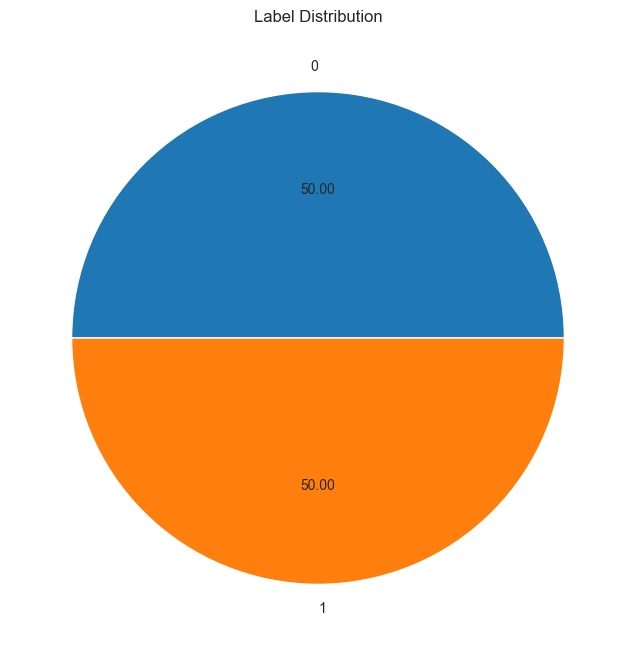

In [12]:
plt.title("Label Distribution")
processed_data.groupby('Class').size().plot(kind='pie', autopct='%.2f', figsize=(8,8))

In [13]:
# Normalize the data
scaler = MinMaxScaler()
normalize_data = processed_data.columns[:-1]
processed_data[normalize_data] = scaler.fit_transform(processed_data[normalize_data])
processed_data.head()

,Header_Length,Protocol Type,Duration,Rate,Srate,Drate,fin_flag_number,syn_flag_number,rst_flag_number,psh_flag_number,...,Std,Tot size,IAT,Number,Magnitue,Radius,Covariance,Variance,Weight,Class
16047,0.000014,0.417647,0.250980,0.019272,0.019272,0.0,0.0,0.0,0.0,0.5,...,0.066873,0.036209,9.999685e-01,0.321429,0.134034,0.066849,0.005081,0.9,0.153941,0
16048,0.000014,0.276471,0.195686,0.028014,0.028014,0.0,0.0,0.0,0.0,0.2,...,0.082858,0.056793,9.999685e-01,0.892857,0.093829,0.083312,0.010238,1.0,1.000000,0
16049,0.000029,0.352941,0.250980,0.000002,0.000002,0.0,0.0,0.0,0.0,0.5,...,0.014177,0.026223,7.565624e-09,0.321429,0.066813,0.014172,0.000240,0.9,0.153941,0
16050,0.000030,0.352941,0.250980,0.003480,0.003480,0.0,0.0,0.0,0.0,0.5,...,0.021667,0.024796,9.999685e-01,0.892857,0.073869,0.021470,0.000462,1.0,1.000000,0
16051,0.000058,0.417647,0.226275,0.000001,0.000001,0.0,0.0,0.0,0.0,0.4,...,0.096705,0.065897,8.154860e-09,0.321429,0.103867,0.096670,0.022554,0.9,0.153941,0


In [14]:
# Shuffle the dataset
processed_data = processed_data.sample(frac=1).reset_index(drop=True)
processed_data.head()

,Header_Length,Protocol Type,Duration,Rate,Srate,Drate,fin_flag_number,syn_flag_number,rst_flag_number,psh_flag_number,...,Std,Tot size,IAT,Number,Magnitue,Radius,Covariance,Variance,Weight,Class
0,0.003575,1.000000,0.250980,6.760040e-02,6.760040e-02,0.0,0.0,0.00,0.00,0.0,...,0.000000,0.005435,4.996706e-01,0.607143,0.018203,0.000000,0.000000e+00,0.0,0.576970,1
1,0.014769,0.417647,0.325882,8.829516e-07,8.829516e-07,0.0,0.0,0.00,0.00,0.4,...,0.029804,0.037092,7.616577e-09,0.321429,0.080885,0.029793,1.168562e-03,0.9,0.153941,0
2,0.021212,0.482353,0.250980,5.924315e-07,5.924315e-07,0.0,0.0,0.00,0.00,0.4,...,0.109786,0.140693,9.999579e-01,0.892857,0.102791,0.110577,3.388989e-02,1.0,1.000000,0
3,0.000011,0.352941,0.250980,2.946122e-06,2.946122e-06,0.0,0.0,0.98,0.02,0.0,...,0.000248,0.010054,4.997735e-01,0.607143,0.031977,0.000248,6.294608e-07,0.1,0.576970,1
4,0.338213,0.352941,0.219608,3.426595e-03,3.426595e-03,0.0,0.0,0.00,0.00,0.1,...,0.000000,1.000000,7.565894e-09,0.321429,1.000000,0.000000,0.000000e+00,0.0,0.153941,0


In [15]:
processed_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 385464 entries, 0 to 385463
Data columns (total 46 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Header_Length    385464 non-null  float64
 1   Protocol Type    385464 non-null  float64
 2   Duration         385464 non-null  float64
 3   Rate             385464 non-null  float64
 4   Srate            385464 non-null  float64
 5   Drate            385464 non-null  float64
 6   fin_flag_number  385464 non-null  float64
 7   syn_flag_number  385464 non-null  float64
 8   rst_flag_number  385464 non-null  float64
 9   psh_flag_number  385464 non-null  float64
 10  ack_flag_number  385464 non-null  float64
 11  ece_flag_number  385464 non-null  float64
 12  cwr_flag_number  385464 non-null  float64
 13  ack_count        385464 non-null  float64
 14  syn_count        385464 non-null  float64
 15  fin_count        385464 non-null  float64
 16  rst_count        385464 non-null  floa

In [16]:
processed_data.describe()

,Header_Length,Protocol Type,Duration,Rate,Srate,Drate,fin_flag_number,syn_flag_number,rst_flag_number,psh_flag_number,...,Std,Tot size,IAT,Number,Magnitue,Radius,Covariance,Variance,Weight,Class
count,385464.000000,385464.000000,385464.000000,3.854640e+05,3.854640e+05,385464.0,385464.000000,385464.000000,385464.000000,385464.000000,...,385464.000000,385464.000000,3.854640e+05,385464.000000,385464.000000,385464.000000,385464.000000,385464.000000,385464.000000,385464.000000
mean,0.022057,0.434710,0.269198,3.775875e-03,3.775875e-03,0.0,0.003715,0.082243,0.020546,0.213653,...,0.046871,0.054639,4.999316e-01,0.607103,0.091445,0.046807,0.018807,0.464998,0.576917,0.500000
std,0.078325,0.282073,0.096961,1.417722e-02,1.417722e-02,0.0,0.027907,0.254873,0.101169,0.246775,...,0.116337,0.166278,3.567174e-01,0.203867,0.174282,0.116356,0.078124,0.459216,0.301812,0.500001
min,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000011,0.352941,0.250980,6.965165e-07,6.965165e-07,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.005435,8.156635e-09,0.321429,0.018203,0.000000,0.000000,0.000000,0.153941,0.000000
50%,0.002939,0.352941,0.250980,1.899352e-06,1.899352e-06,0.0,0.000000,0.000000,0.000000,0.000000,...,0.002091,0.016304,4.997740e-01,0.607143,0.050673,0.002022,0.000024,0.260000,0.576970,0.500000
75%,0.017468,0.417647,0.250980,1.027334e-04,1.027334e-04,0.0,0.000000,0.000000,0.000000,0.500000,...,0.025201,0.026562,9.999532e-01,0.892857,0.082017,0.024994,0.000782,0.900000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000e+00,1.000000e+00,0.0,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000e+00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Model Creation and Training

In [17]:
# Extract features and labels
X = processed_data.drop(columns=['Class']).values
y = processed_data['Class'].values
print(f'X: {X.shape}, y: {y.shape}')

X: (385464, 45), y: (385464,)


In [18]:
# Split the data into train, validation, and test sets
# 70% training, 15% validation, 15% testing
X_train, X_rest, y_train, y_rest = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_rest, y_rest, test_size=0.5, random_state=42)
print('Train set:', X_train.shape, y_train.shape)
print('Validation set:', X_val.shape, y_val.shape)
print('Test set:', X_test.shape, y_test.shape)

Train set: (269824, 45) (269824,)
Validation set: (57820, 45) (57820,)
Test set: (57820, 45) (57820,)


In [19]:
# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.int64)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.int64)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.int64)

# Create data loaders
batch_size = 128
train_loader = DataLoader(TensorDataset(X_train, y_train),
                          batch_size=batch_size, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=batch_size)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=batch_size)

In [20]:
# Define the model
class CNN_LSTM_Model(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(CNN_LSTM_Model, self).__init__()

        # CNN layers for spatial feature extraction
        self.cnn = nn.Sequential(
            nn.Conv1d(in_channels=input_size, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2),
            nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2)
        )

        # LSTM layers for temporal feature extraction
        self.lstm = nn.LSTM(
            input_size=128,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=0.2
        )

        # Fully connected layer for classification
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        if x.dim() == 2: 
            x = x.unsqueeze(2)
        x = x.permute(0, 2, 1)
        out = self.cnn(x)
        out = out.permute(0, 2, 1)
        out, _ = self.lstm(out)
        out = self.fc(out[:, -1, :])
        return out

In [21]:
# Initialize the model, loss function, and optimizer
input_size = 1
hidden_size = 256
num_layers = 2
num_classes = 2

model = CNN_LSTM_Model(input_size, hidden_size, num_layers, num_classes).to('cpu')
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
print(model)

CNN_LSTM_Model(
  (cnn): Sequential(
    (0): Conv1d(1, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (4): ReLU()
    (5): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (lstm): LSTM(128, 256, num_layers=2, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=256, out_features=2, bias=True)
)


In [22]:
# Training function
def train(model, dataloader, criterion, optimizer):
    model.train()
    running_loss = 0.0

    for inputs, labels in dataloader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)

    return running_loss / len(dataloader.dataset)

# Evaluation function
def evaluate(model, dataloader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Compute additional metrics
    accuracy = correct / len(dataloader.dataset)
    precision = precision_score(all_labels, all_preds, average='macro')
    recall = recall_score(all_labels, all_preds, average='macro')
    f1 = f1_score(all_labels, all_preds, average='macro')

    return running_loss / len(dataloader.dataset), accuracy, precision, recall, f1

In [23]:
# Train and evaluate the model
num_epochs = 10
for epoch in range(num_epochs):
    train_loss = train(model, train_loader, criterion, optimizer)
    val_loss, val_acc, val_prec, val_rec, val_f1 = evaluate(model, val_loader, criterion)
    print(
        f"Epoch {epoch + 1}/{num_epochs}: <Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}, Val Acc: {val_acc:.6f}, Val Prec: {val_prec:.6f}, Val Rec: {val_rec:.6f}, Val F1: {val_f1:.6f}>")

Epoch 1/10: <Train Loss: 0.030262, Val Loss: 0.013013, Val Acc: 0.997561, Val Prec: 0.997573, Val Rec: 0.997561, Val F1: 0.997561>
Epoch 2/10: <Train Loss: 0.012328, Val Loss: 0.012802, Val Acc: 0.997423, Val Prec: 0.997436, Val Rec: 0.997422, Val F1: 0.997423>
Epoch 3/10: <Train Loss: 0.011863, Val Loss: 0.012322, Val Acc: 0.997527, Val Prec: 0.997539, Val Rec: 0.997526, Val F1: 0.997527>
Epoch 4/10: <Train Loss: 0.011343, Val Loss: 0.012061, Val Acc: 0.997769, Val Prec: 0.997780, Val Rec: 0.997768, Val F1: 0.997769>
Epoch 5/10: <Train Loss: 0.010938, Val Loss: 0.011056, Val Acc: 0.997734, Val Prec: 0.997744, Val Rec: 0.997734, Val F1: 0.997734>
Epoch 6/10: <Train Loss: 0.010456, Val Loss: 0.010663, Val Acc: 0.997838, Val Prec: 0.997848, Val Rec: 0.997837, Val F1: 0.997838>
Epoch 7/10: <Train Loss: 0.010210, Val Loss: 0.011039, Val Acc: 0.997821, Val Prec: 0.997830, Val Rec: 0.997820, Val F1: 0.997821>
Epoch 8/10: <Train Loss: 0.010083, Val Loss: 0.010300, Val Acc: 0.997752, Val Prec:

In [24]:
# Evaluate on the test set
loss, accuracy, precision, recall, f1 = evaluate(model, test_loader, criterion)
print(f'Test Loss: {loss:.6f}'
      f'\nAccuracy: {accuracy:.6f}'
      f'\nPrecision: {precision:.6f}'
      f'\nRecall: {recall:.6f}'
      f'\nF1-score: {f1:.6f}')

Test Loss: 0.009629
Accuracy: 0.997873
Precision: 0.997869
Recall: 0.997885
F1-score: 0.997873
